**Deep Audio Classifier Model using Convolutional Neural Networks**

**Algorithm description**:-

*   We are having a dataset of various audio clips containing Capuchin birds and Not Capuchin birds and some real life audio clips of forests.We need to train a model to detect the Capuchin audio perfectly from the forest audio files accurately.



   **The steps we follow are** :-



*   Convert audio data to waveforms
*    Transform waveform to spectrogram


*   Classify Capuchin bird calls














In [ ]:
!pip install tensorflow tensorflow-io matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 18.3 MB/s eta 0:00:00


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

z-by-hp-unlocked-challenge-3-signal-processing.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
dataset = '/content/z-by-hp-unlocked-challenge-3-signal-processing.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
CAPUCHIN_FILE = os.path.join('/content', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('/content', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
CAPUCHIN_FILE

'/content/Parsed_Capuchinbird_Clips/XC3776-3.wav'

**Downsampling:-** Our initial dataset has a sampling freequency of 44100 Hz which is very high. So we need to downsample the audio for training. The audio is being downsampled to 16000Hz

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

**Plotting the waves**:-

We can observe that the blue graph is the Capuchin wave and the orange wave is the Not Capuchin wave.

So we can distinguish them clearly

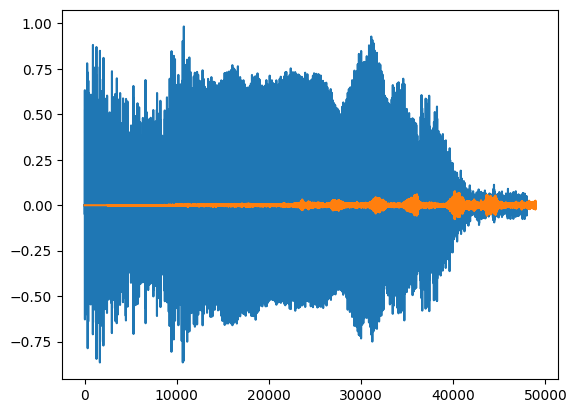

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POS = os.path.join('/content', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content', 'Parsed_Not_Capuchinbird_Clips')

**Creating Tensorflow datasets**:-

We now convert the waveforms into tensors to apply the Tensorflow library,

waves of Capuchin as "**pos**" and Non Capuchin as '**neg**'

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

**Add labels and Combine Positive and Negative Samples**:-

We are adding labels to the positive and negative samples and combining them together as a single dataset

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

**Determining Average Length of a Capuchin Call**:-



Calculating the Wave Cycle Length of Capuchin Call

In [ ]:
lengths = []
for file in os.listdir(os.path.join('/content', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

**Calculating Mean, Min and Max of the wave cycle length**

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [ ]:
 54156/16000

3.38475

So the average time of a Capuchin call is approximately 3 seconds

**Build Preprocessing Function to Convert to Spectrogram**:-

*   The loaded waveform is then trimmed or padded to a length of 48000 samples (which corresponds to 3 seconds of audio assuming a sample rate of 16 kHz).
*   If the waveform is shorter than 48000 samples, it pads the waveform with zeros at the beginning to make it 48000 samples long. This is done using TensorFlow's tf.zeros() function.

*   The function then computes the Short-Time Fourier Transform (STFT) of the audio waveform using TensorFlow's tf.signal.stft() function.






In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

**Test Out the Function and Viz the Spectrogram**:-

Now the wave is converted into a spectrogram which is in the format of an image and can be plotted as below. We can observe the difference between the spectrograms of the Capuchin and non-Capuchin spectrograms.

Now we can apply a CNN on these spectrograms

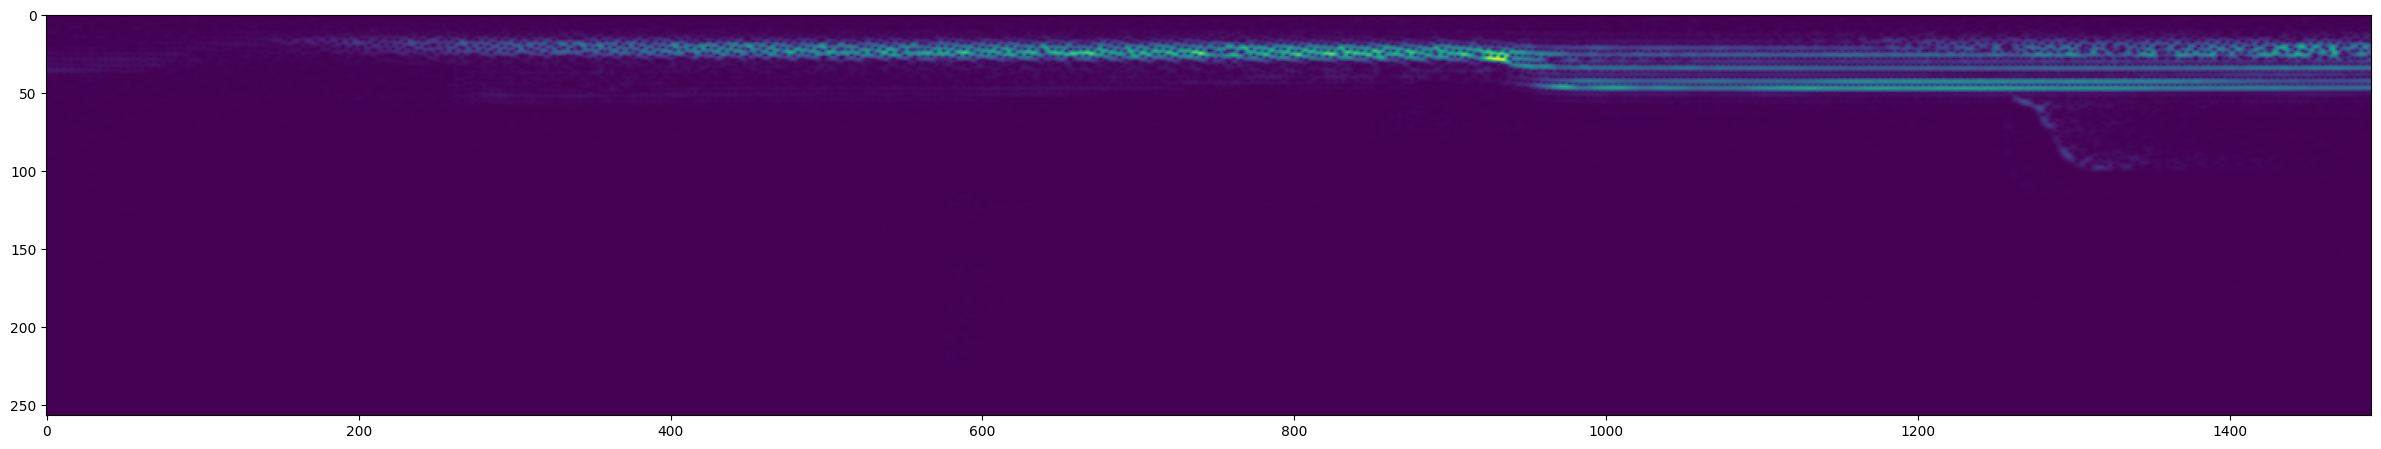

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

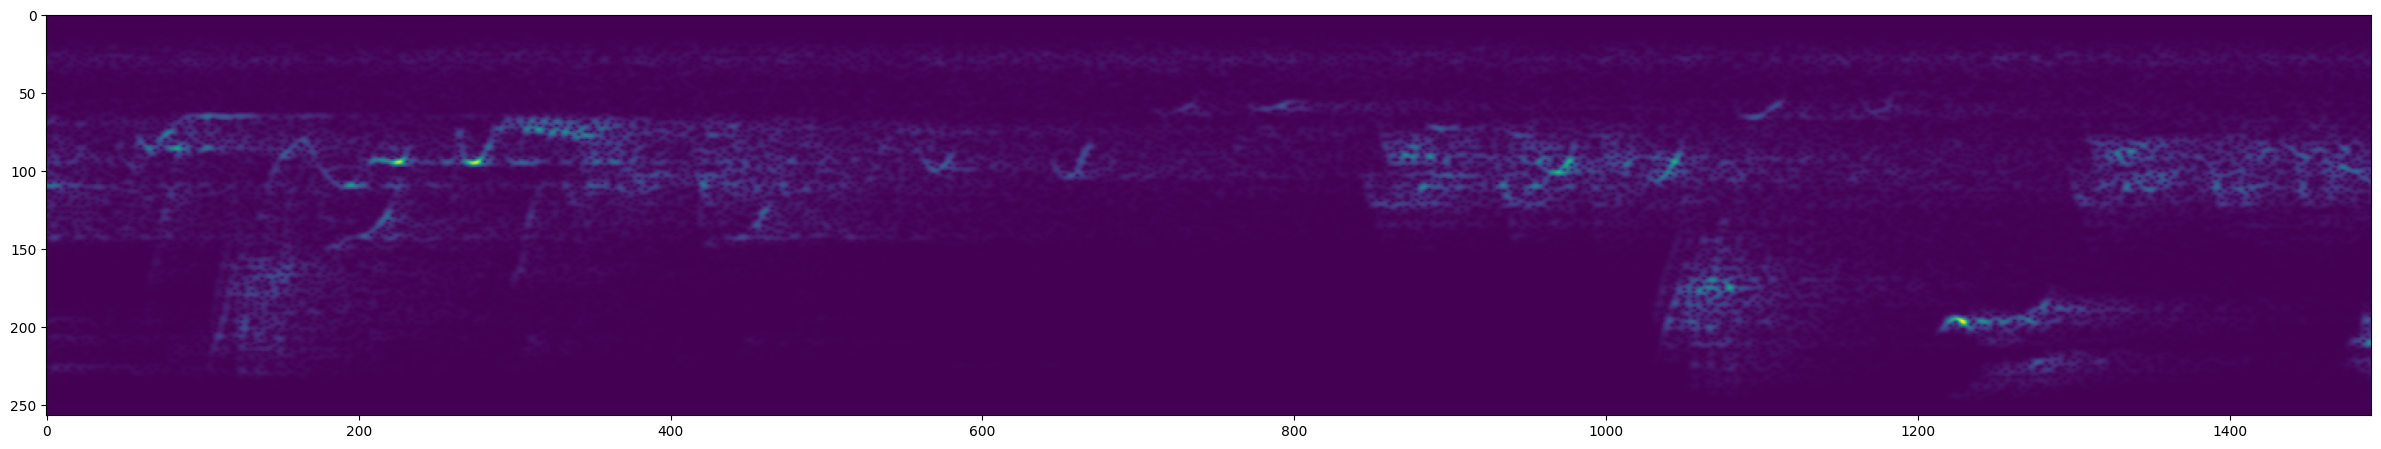

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

**Create a Tensorflow Data Pipeline**:-

This pipeline mechanism sets up a data pipeline for training a machine learning model on audio data. It preprocesses the data, caches it for efficiency, shuffles it for randomness, batches it for training, and prefetches batches to optimize performance.

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
len(data)*.7

35.699999999999996

**Split into Training and Testing Partitions**:-

Now we are splitting our data as 70% for training and 30% for testing the model i.e 36 batches for training and the remaining batches for testing

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

In [ ]:
 from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

**Build Deep Learning Model**:-



**CNN Architecture:-**

We used **Two** **(2)** convolutional layers, each followed by a max-pooling layer because if we use further more convolutional layers there may be a chance of overfitting as already our accuracy is almost 100% now.

Convolutional layers with **3x3** filters are suitable choices in CNN architectures for basic image processing, as they capture local spatial patterns effectively.


The number of filters **(16)** chosen for each convolutional layer are relatively small, because we are just using for a normal task of filtering with minimum computation

**Max-pooling layers** help in reducing the spatial dimensions of the feature maps, leading to translation invariance and reducing the computational burden.

**Two dense layers** are used, one with **128 units** and another with 1 unit.
The dense layers are responsible for learning high-level features from the flattened representation obtained from the convolutional layers.

**ReLU activation** is used in the **hidden dense layer** (128 units), which helps introduce non-linearity and capture complex patterns in the data.

**Sigmoid activation** is used in the **output layer (1 unit)** for binary classification tasks


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf

# Define your CNN model
model = Sequential()

# First Convolutional Layer with MaxPooling
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1491, 257, 1)))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Layer with MaxPooling
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





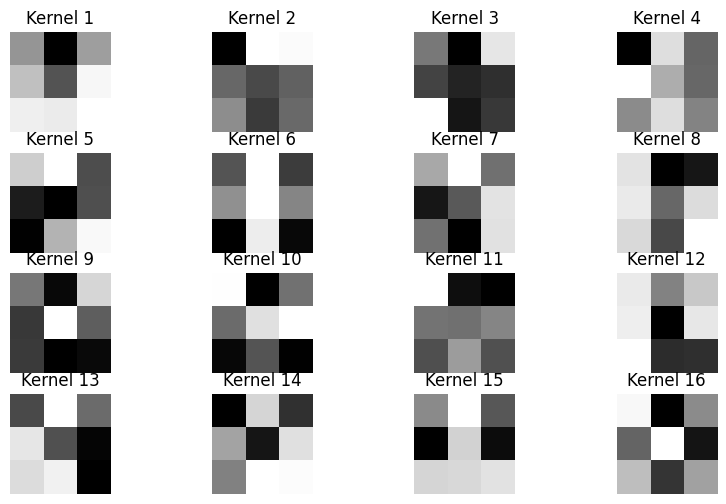

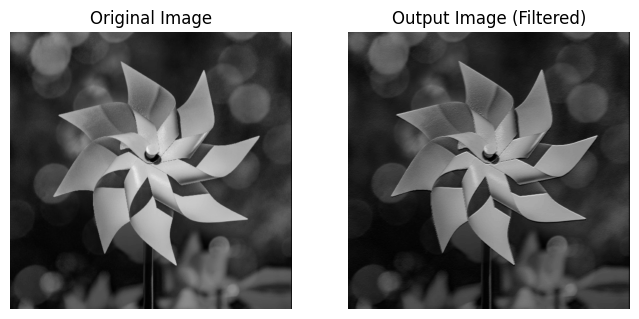

In [112]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming model is your pre-trained CNN model

# Load your input image from storage
input_image_path = "/content/edgeflower.jpg"  # Change this to your image path
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Get the weights of the first convolutional layer
first_conv_layer_weights = model.layers[0].get_weights()[0]

# Reshape the weights to (height, width, channels, num_filters)
weights = first_conv_layer_weights.reshape((3, 3, 1, 16))

# Visualize the weights
plt.figure(figsize=(10, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(weights[:, :, 0, i], cmap='gray')
    plt.title('Kernel {}'.format(i+1))
    plt.axis('off')
plt.show()

# Pass the input image through the first kernel
output_image = cv2.filter2D(input_image, -1, weights[:, :, 0, 0])

# Display the output image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Output Image (Filtered)')
plt.axis('off')
plt.show()


The kernels used in the first Covolutional layer have been displayed above. The first kernel in the first Covolutional layer has been applied on the sample image. From the output we can say that the kernel doesn't acts as a edge/corner detector.

 The interpretation of the filtered output may not directly correspond to traditional image processing filters like edge detectors or corner detectors, as the weights of the convolutional layer are learned by the network during training.







In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 744, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 371, 62, 16)       0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 368032)            0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [ ]:
train_size = 36
test_size = 15

train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)

# Train the model
epochs = 4
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train the model for one epoch
    model.fit(train_data, epochs=1)

    # Evaluate training accuracy
    train_loss, train_acc = model.evaluate(train_data)
    print(f"Training accuracy: {train_acc}")

Epoch 1/4
36/36 [==============================] - 1s 23ms/step - loss: 0.0921 - accuracy: 0.9670
Training accuracy: 0.9670138955116272
Epoch 2/4
36/36 [==============================] - 1s 26ms/step - loss: 0.0340 - accuracy: 0.9931
Training accuracy: 0.9930555820465088
Epoch 3/4
36/36 [==============================] - 1s 25ms/step - loss: 0.0039 - accuracy: 1.0000
Training accuracy: 1.0
Epoch 4/4
36/36 [==============================] - 1s 24ms/step - loss: 0.0023 - accuracy: 1.0000
Training accuracy: 1.0


**The Training accuracy of the model is 100%**

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

15/15 [==============================] - 1s 25ms/step - loss: 0.1796 - accuracy: 0.9957
Test accuracy: 0.995726466178894


**The testing accuracy of the model is 99.57%**

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 4s 105ms/step - loss: 0.0701 - accuracy: 0.9965 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 2/4
36/36 [==============================] - 4s 98ms/step - loss: 0.0195 - accuracy: 0.9931 - val_loss: 9.9715e-04 - val_accuracy: 1.0000
Epoch 3/4
36/36 [==============================] - 3s 87ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9957
Epoch 4/4
36/36 [==============================] - 3s 86ms/step - loss: 8.8952e-04 - accuracy: 1.0000 - val_loss: 6.6419e-05 - val_accuracy: 1.0000


In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


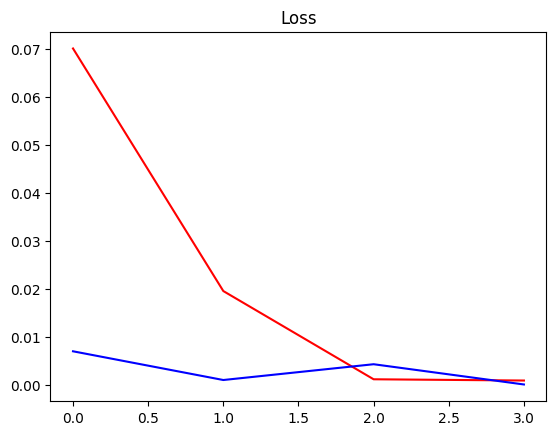

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

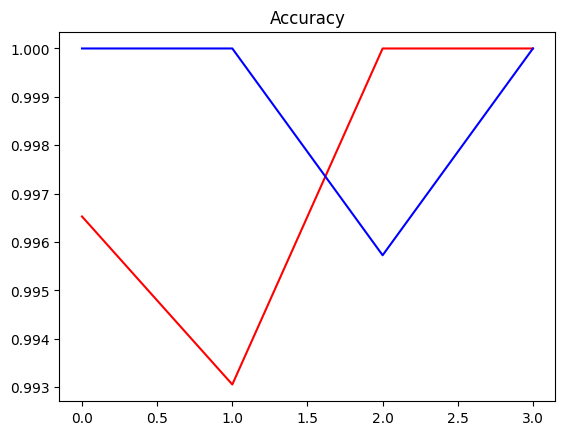

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 76ms/step


In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat

[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]

In [ ]:
y_test.astype(int)

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0])

In [ ]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [ ]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

**Testing the model on real-life audio files of a forest:-**

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('/content', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

Splitting the long duration audio file into 3 sec chunks to test for the Capuchin audio

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

Predicting the output

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.95 else 0 for prediction in yhat]

1/1 [==============================] - 0s 445ms/step


In [ ]:
yhat

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

5

So we have detected 5 calls of the Capuchin from the audio file

**Result:-**

We have successfully trained a CNN model to detect a particular audio from a audio file containing various audios with a test accuracy of **99.57%**